# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [59]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.naive_bayes import MultinomialNB

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from bs4 import BeautifulSoup

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

from prettytable import PrettyTable

In [60]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [61]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [62]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [63]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [64]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [65]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [66]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [67]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [68]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [04:41<00:00, 1291.71it/s]


<b>We are preprocessing review summary as well because we need to generate a column using the length of review summary.</b/>

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [69]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summaries = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_Summaries.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [05:54<00:00, 1027.30it/s]


In [70]:
print(preprocessed_reviews[:3])
print(preprocessed_Summaries[:3])

['witty little book makes son laugh loud recite car driving along always sing refrain learned whales india drooping roses love new words book introduces silliness classic book willing bet son still able recite memory college', 'grew reading sendak books watching really rosie movie incorporates love son loves however miss hard cover version paperbacks seem kind flimsy takes two hands keep pages open', 'fun way children learn months year learn poems throughout school year like handmotions invent poem']
['every book educational', 'love book miss hard cover version', 'chicken soup rice months']


<b> Storing the cleaned text and summary into columns</b>

In [71]:
# creating other column for the cleaned data
final['cleaned_Texts']=preprocessed_reviews
final['cleaned_Summaries']=preprocessed_Summaries

<b>Sort the data by time and get top 100k Records</b>

In [72]:
final_sorted=final.sort_values(by='Time')[:100000]   # rest parameters are default

<b>Important point </b>

<p>
We are doing 3 attempts here to apply the naive bayes model and improve using feature enginnering method.<br><br>

<b>Attempt1:</b> Use review Text only and binarize it using bow (set1) and tfidf(set2) and solve the problem.<br>
<b>Attempt2:</b> Use review Text only and binarize it using bow (set1) and tfidf(set2).Create two extra columns
using the length of review texts and length of review summary.<br>
<b>Attempt3:</b> Combine both preprocessed review texts and summaries and binarize it using bow (set1) and tfidf(set2).Create one extra column using the length of this combined review text and length of review summary.<br><br>

We will tabulate the results and analyse if there was any improvement due to the feature enginnering we used. <br>
Attempt 3 is not expected in the assignment. So please ignore if this doesnot sound good to you.<br>
</p>

<h1>Important Functions</h1>

In [73]:
def vectorize_standardarize_data(vectorizing_model,train,test):
    '''
    This function takes vectorizing models such as tfidf vectorizer and bow count vectorizer, train and test text data.
    It performs the stanadarization of train and test data.
    Returns: vectorized and standarized train and test datasets.    
    '''
    
    train=vectorizing_model.fit_transform(train)
    test=vectorizing_model.transform(test)

    scalar=StandardScaler(with_mean=False)
    train=scalar.fit_transform(train)
    test=scalar.transform(test)

    return train,test

   
def plot_auc_vs_hyperpameter(param_grid,grid):
    '''
    This function plots the variation of auc of roc for train and cv data using Grid Search.
    Returns : optimal number of neighbours
    '''
    plt.close()
    plt.plot(np.log10(param_grid['alpha']),grid.cv_results_['mean_test_score'],label='Validation AUC')
    plt.plot(np.log10(param_grid['alpha']),grid.cv_results_['mean_train_score'],label='Train AUC')
    
    plt.xlabel('Log of alpha')
    plt.ylabel('Area under ROC Curve')
    plt.title('Area under ROC curve V/S Log of Hyper Parameter for CV and train datasets')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()
    
    optimal_alpha=grid.best_params_['alpha']        
    
    return optimal_alpha


def plot_roc_curve(train_x,train_y,test_x,test_y,estimator):
    '''
    This curve takes train and test datasets, estimator to plot roc curves for train 
    and test datasets. Please initialize the estimator with necessary parameters before calling this function.
    Returns: a dictionary "auc_and_Ypred" containing test data auc and predicted test scores.
    '''
    plt.close()
    estimator.fit(train_x,train_y)
    
    test_y_pred_prob_score=estimator.predict_proba(test_x)[:,1]
    fpr_test,tpr_test,thresholds_test=roc_curve(test_y,test_y_pred_prob_score)
    

    test_y_pred=estimator.predict(test_x)    
    train_y_pred=estimator.predict(train_x)
    
    plt.plot(fpr_test,tpr_test,'r',label='TEST')
    
    train_y_pred_prob_score=estimator.predict_proba(train_x)[:,1]
    fpr_train,tpr_train,thresholds_train=roc_curve(train_y,train_y_pred_prob_score)
    plt.plot(fpr_train,tpr_train,'b',label='TRAIN')
    
    # print auc for roc for test
    print('ROC AUC for test data',roc_auc_score(test_y,test_y_pred_prob_score)) 
    
   
    # plot roc curve
    plt.plot([0,1],[0,1],'k')
    
    plt.title('ROC for TRAIN and TEST data')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid()
    plt.legend()
    plt.show() 
    
    best_auc=roc_auc_score(test_y,test_y_pred_prob_score)
    auc_and_Ypred={}
    auc_and_Ypred['best_auc']=best_auc
    auc_and_Ypred['y_pred_test']=test_y_pred
    auc_and_Ypred['y_pred_train']=train_y_pred
      
    return auc_and_Ypred
  
    
def plot_confusion_matrix(y,y_pred,dataset_type):
    '''
    This function takes test class labels and predicted class labels and plots confusion matrix.
    dataset_type parameter can take two values "Train" and "Test".
    '''

    cm=confusion_matrix(y,y_pred)
    
    label=pd.DataFrame(cm)
    label.iloc[0,0]='TN={}'.format(label.iloc[0,0])
    label.iloc[0,1]='FN={}'.format(label.iloc[0,1])
    label.iloc[1,0]='FP={}'.format(label.iloc[1,0])
    label.iloc[1,1]='TP={}'.format(label.iloc[1,1])
    
    plt.close()
    plt.figure(figsize=(6,4))   

    sns.heatmap(cm,xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'],
                cmap='Dark2',annot=label,linewidths=1,linecolor='black',fmt='s')
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix for ' + dataset_type + ' data')
    plt.show()  


<b> setting up vars and initiaizing the classifiers. </b>

In [74]:

# range of neighbors
param_grid={'alpha':[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]}         

# Initiliaze the multinomial bayes model
mnb=MultinomialNB(fit_prior=True)    # fit_prior=True to learn the probabilities of each classes and predict accordingly.

# gridcv brute force model
grid=GridSearchCV(mnb,param_grid,scoring='roc_auc')


In [97]:
np.log10(param_grid['alpha'])

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

<b>split the data into train and test</b>

In [75]:
train_x,test_x,train_y, test_y=train_test_split(final_sorted[['cleaned_Texts','cleaned_Summaries']],final_sorted['Score'],test_size=0.3)

print('train_x shape:',train_x.shape,'\n','test_x shape:',test_x.shape,'\n','train_y shape:',train_y.shape,'\n','test_y shape:',test_y.shape)

train_x shape: (70000, 2) 
 test_x shape: (30000, 2) 
 train_y shape: (70000,) 
 test_y shape: (30000,)


# [4] Featurization

## [4.1] BAG OF WORDS

<b>Vectorize the data using BOW</b>

In [76]:
#BoW

set1_count_vect=CountVectorizer(max_features=500,dtype='float64')           #
set1_x, set1_x_test = vectorize_standardarize_data(set1_count_vect,train_x['cleaned_Texts'],test_x['cleaned_Texts'])

print("the type of train and test vectorizer ",type(set1_x),type(set1_x_test))
print("the shape of train and test vectorizer ",set1_x.get_shape(),set1_x_test.get_shape())
print("the number of unique words in train and test", set1_x.get_shape()[1],set1_x_test.get_shape()[1])

the type of train and test vectorizer  <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500


## [4.2] Bi-Grams and n-Grams.

In [81]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

<b>vectorize the data using TFIDF</b>

In [77]:
#TFIDF
set2_tfidf_vect=TfidfVectorizer(max_features=500,dtype='float64',ngram_range=(1,2))
set2_x, set2_x_test = vectorize_standardarize_data(set2_tfidf_vect,train_x['cleaned_Texts'],test_x['cleaned_Texts'])


print("the type of train and test vectorizer ",type(set2_x),type(set2_x_test))
print("the shape of train and test vectorizer ",set2_x.get_shape(),set2_x_test.get_shape())
print("the number of unique words in train and test", set2_x.get_shape()[1],set2_x_test.get_shape()[1])


the type of train and test vectorizer  <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>Attempt1: Binarize and standardize only review texts using bow (set1) and tfidf(set2).</h1>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

<b> Plot Area under ROC curve V/S Alpha for train and cross validation data, ROC curve for train and test data, confusion matrix for set1(BOW) data.</b>

---------------------- BOW--------------------------


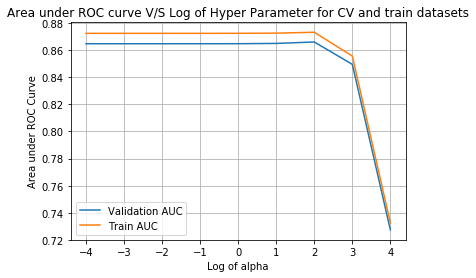

ROC AUC for test data 0.865500230445388


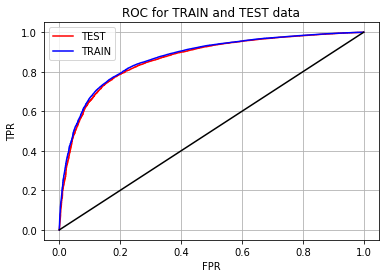

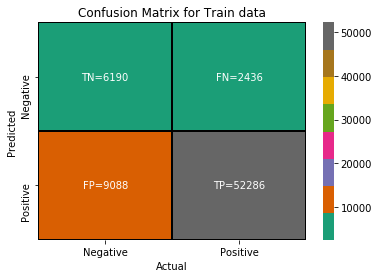

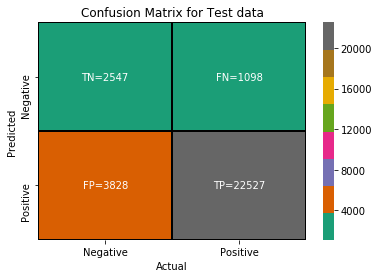

set1_optimal_alpha: 100 set1_best_auc: 0.865500230445388


In [78]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- BOW--------------------------')

# train the grid and find optimal number of neighbors
grid.fit(set1_x,train_y)    
set1_optimal_alpha=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set1_clf=MultinomialNB(fit_prior=True,alpha=set1_optimal_alpha)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,train_y,set1_x_test,test_y,set1_clf)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set1_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set1_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set1_optimal_alpha:',set1_optimal_alpha,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW','Naive Bayes:Attempt1',set1_optimal_alpha,set1_auc_and_Ypred['best_auc']]


### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

<b>From Naive Bayes model we will get coef_ and from BOW vectorizer we will get feature names. Using these two we find top 10 positive and negative class important features.</b>

In [79]:
# Please write all the code with proper documentation

set1_feature_importance=pd.DataFrame([set1_count_vect.get_feature_names(),list(set1_clf.feature_log_prob_[1].ravel())],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features

,feature,log_probability
350,product,-5.37978
175,flavor,-5.3314
39,best,-5.31989
435,taste,-5.27855
311,one,-5.26239
264,love,-5.22279
251,like,-5.12307
203,good,-5.04196
206,great,-4.9732
303,not,-4.86348


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [81]:
# Please write all the code with proper documentation

set1_feature_importance=pd.DataFrame([set1_count_vect.get_feature_names(),list(set1_clf.feature_log_prob_[0].ravel())],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 negative class features

,feature,log_probability
300,no,-5.20664
30,bad,-5.17318
127,disappointed,-5.1518
286,money,-5.14516
311,one,-5.14122
435,taste,-4.95511
251,like,-4.93807
350,product,-4.91214
493,would,-4.85871
303,not,-4.34541


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

<b> Plot Area under ROC curve V/S Alpha for train and cross validation data, ROC curve for train and test data, confusion matrix for set2(TFIDF) data.</b>

--------------- TFIDF-------------------


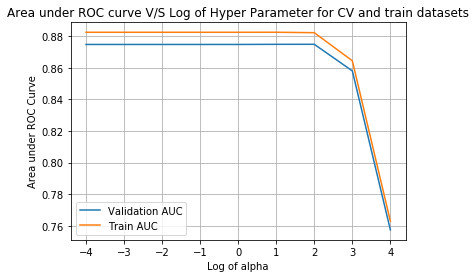

ROC AUC for test data 0.8787793707266434


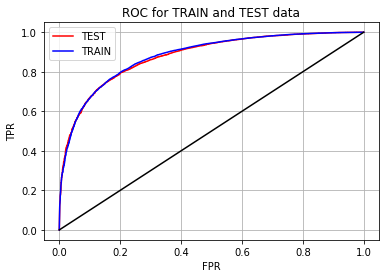

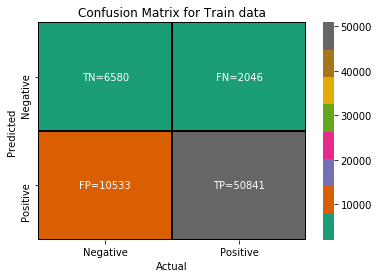

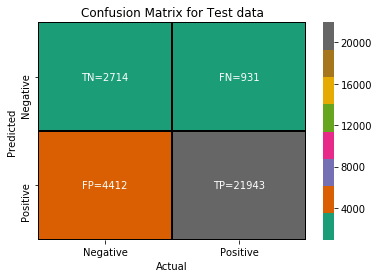

set2_optimal_alpha: 100 set2_best_auc: 0.8787793707266434


In [83]:
# Please write all the code with proper documentation

########
# TFIDF#
########

print('--------------- TFIDF-------------------')

# train the grid and find optimal number of neighbors
grid.fit(set2_x,train_y)
set2_optimal_alpha=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set2_clf=MultinomialNB(fit_prior=True,alpha=set2_optimal_alpha)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,train_y,set2_x_test,test_y,set2_clf)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set2_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set2_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# store the set2 results
print('set2_optimal_alpha:',set2_optimal_alpha,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF','Naive Bayes:Attempt1',set2_optimal_alpha,set2_auc_and_Ypred['best_auc']]


### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

<b> From Naive Bayes model we will get coef_ and from TFIDF vectorizer we will get feature names. Using these two we find top 10 positive and negative class important features.</b>

In [84]:
# Please write all the code with proper documentation

set2_feature_importance=pd.DataFrame([set2_tfidf_vect.get_feature_names(),list(set2_clf.feature_log_prob_[1].ravel())],index=['feature','log_probability']).T

set2_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features

,feature,log_probability
36,best,-5.3582
349,product,-5.34298
167,flavor,-5.30987
434,taste,-5.25973
258,love,-5.24798
311,one,-5.24254
245,like,-5.09189
196,good,-5.06028
199,great,-5.01165
297,not,-4.7155


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [86]:
# Please write all the code with proper documentation

set2_feature_importance=pd.DataFrame([set2_tfidf_vect.get_feature_names(),list(set2_clf.feature_log_prob_[0].ravel())],index=['feature','log_probability']).T

set2_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 negative class features

,feature,log_probability
27,bad,-5.14842
120,disappointed,-5.14535
279,money,-5.14237
494,would not,-5.12412
311,one,-5.09382
349,product,-4.97562
434,taste,-4.92315
245,like,-4.87109
493,would,-4.79967
297,not,-4.10691


<b>Tabulate the result from attempt1</b>

In [88]:
# Please compare all your models using Prettytable library
table=PrettyTable(field_names=['Vectorizer','Model','HyperParameter','AUC'])

#We will use set1 and set2 for Naive Bayes implementations for BOW and TFIDF respectively.

table.add_row(set1_result)
table.add_row(set2_result)

<h1>Attempt2: Use review Text only and binarize it using bow (set1) and tfidf(set2).Create two extra columns using the length of review texts and length of review summary.<h1>

<b> We find the length of review summaries and review texts and standarize them. </b> 

In [89]:
# find the lengths of review summary and review text columns and standarize them

train_x_text_summary_lengths = [ [ len(text.split()), len(summary.split()) ] for text, summary in zip(train_x['cleaned_Texts'],train_x['cleaned_Summaries']) ]

test_x_text_summary_lengths = [ [ len(text.split()), len(summary.split()) ] for text, summary in zip(test_x['cleaned_Texts'],test_x['cleaned_Summaries']) ]

scalar=StandardScaler(with_mean=False)
train_x_text_summary_lengths=scalar.fit_transform(train_x_text_summary_lengths)
test_x_text_summary_lengths=scalar.transform(test_x_text_summary_lengths)


print('train_x_text_summary_lengths:',len(train_x_text_summary_lengths),'\n','test_x_text_summary_lengths:',len(test_x_text_summary_lengths))
print('set1_x: ',set1_x.shape,'\n','set1_x_test:',set1_x_test.shape,'\n','set2_x:',set2_x.shape,'\n','set2_x_test:',set2_x_test.shape)

train_x_text_summary_lengths: 70000 
 test_x_text_summary_lengths: 30000
set1_x:  (70000, 500) 
 set1_x_test: (30000, 500) 
 set2_x: (70000, 500) 
 set2_x_test: (30000, 500)


<b>Add two additional columns into the vectorized data. Note that we have not again vectorized the data and are using the same vectorized data as attempt1 set1 (BOW) and set2(TFIDF) </b>

In [90]:
# Adding 2 new columns to existing data.

set1_x=np.hstack((set1_x.toarray(), train_x_text_summary_lengths))
set1_x_test=np.hstack((set1_x_test.toarray(), test_x_text_summary_lengths))

set2_x=np.hstack((set2_x.toarray(), train_x_text_summary_lengths))
set2_x_test=np.hstack((set2_x_test.toarray(), test_x_text_summary_lengths))

print('set1_x: ',set1_x.shape,'\n','set1_x_test:',set1_x_test.shape,'\n','set2_x:',set2_x.shape,'\n','set2_x_test:',set2_x_test.shape)

set1_x:  (70000, 502) 
 set1_x_test: (30000, 502) 
 set2_x: (70000, 502) 
 set2_x_test: (30000, 502)


<b> Plot Area under ROC curve V/S Alpha for train and cross validation data, ROC curve for train and test data, confusion matrix for set1(BOW) data.</b>

---------------------- BOW--------------------------


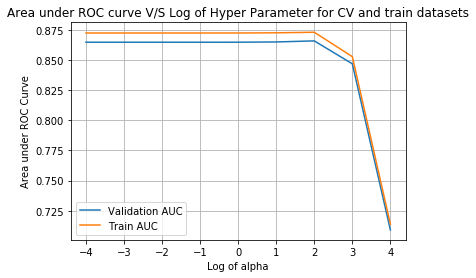

ROC AUC for test data 0.8653955241806306


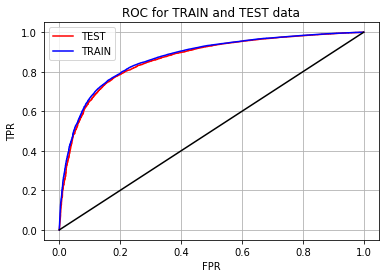

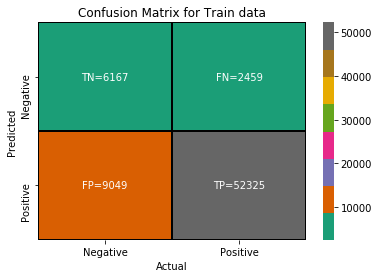

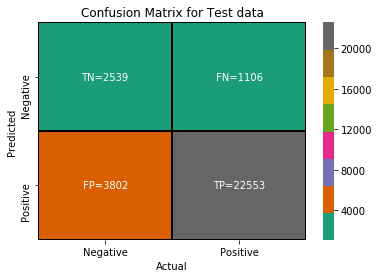

set1_optimal_alpha: 100 set1_best_auc: 0.8653955241806306


In [91]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- BOW--------------------------')

# train the grid and find optimal number of neighbors
grid.fit(set1_x,train_y)    
set1_optimal_alpha=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set1_clf=MultinomialNB(fit_prior=True,alpha=set1_optimal_alpha)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,train_y,set1_x_test,test_y,set1_clf)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set1_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set1_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set1_optimal_alpha:',set1_optimal_alpha,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW','Naive Bayes:Attempt2',set1_optimal_alpha,set1_auc_and_Ypred['best_auc']]


<b> From Naive Bayes model we will get coef_ and from BOW vectorizer we will get feature names. Using these two we find top 10 positive and negative class important features.</b> 

In [92]:
# feature importance of attempt2
# Please write all the code with proper documentation

set1_feature_importance=pd.DataFrame([set1_count_vect.get_feature_names(),list(set1_clf.feature_log_prob_[1][:500])],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features


,feature,log_probability
350,product,-5.41396
175,flavor,-5.36558
39,best,-5.35407
435,taste,-5.31273
311,one,-5.29657
264,love,-5.25697
251,like,-5.15725
203,good,-5.07614
206,great,-5.00738
303,not,-4.89766


In [94]:
# Please write all the code with proper documentation

set1_feature_importance=pd.DataFrame([set1_count_vect.get_feature_names(),list(set1_clf.feature_log_prob_[0][:500])],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 negative class features

,feature,log_probability
300,no,-5.23932
30,bad,-5.20586
127,disappointed,-5.18449
286,money,-5.17784
311,one,-5.1739
435,taste,-4.98779
251,like,-4.97075
350,product,-4.94482
493,would,-4.89139
303,not,-4.37809


<b> Plot Area under ROC curve V/S Alpha for train and cross validation data, ROC curve for train and test data, confusion matrix for set2(TFIDF) data.</b>

--------------- TFIDF-------------------


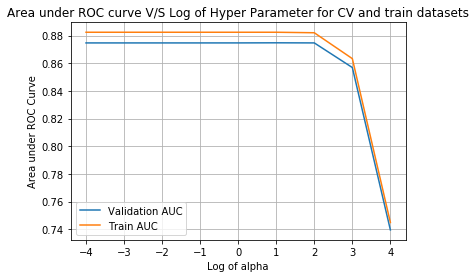

ROC AUC for test data 0.87856180217402


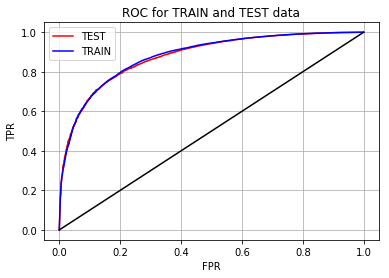

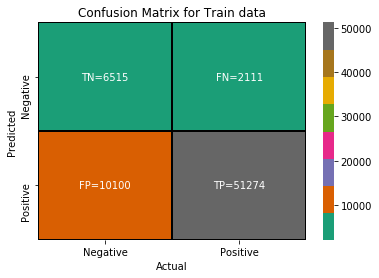

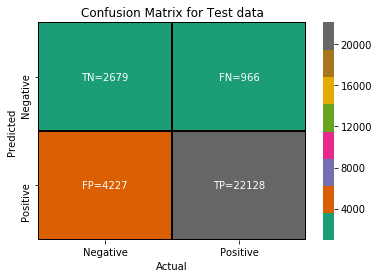

set2_optimal_alpha: 10 set2_best_auc: 0.87856180217402


In [96]:

# Please write all the code with proper documentation

########
# TFIDF#
########

print('--------------- TFIDF-------------------')

# train the grid and find optimal number of neighbors
grid.fit(set2_x,train_y)
set2_optimal_alpha=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set2_clf=MultinomialNB(fit_prior=True,alpha=set2_optimal_alpha)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,train_y,set2_x_test,test_y,set2_clf)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set2_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set2_auc_and_Ypred['y_pred_test'],dataset_type='Test')


# store the set2 results
print('set2_optimal_alpha:',set2_optimal_alpha,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF','Naive Bayes:Attempt2',set2_optimal_alpha,set2_auc_and_Ypred['best_auc']]


<b> From Naive Bayes model we will get coef_ and from TFIDF vectorizer we will get feature names. Using these two we find top 10 positive and negative class important features. </b> 

In [97]:
# Please write all the code with proper documentation


feature_importance=pd.DataFrame([set2_tfidf_vect.get_feature_names(),list(set2_clf.feature_log_prob_[1][:500])],index=['feature','log_probability']).T

feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features



,feature,log_probability
36,best,-5.38778
349,product,-5.3725
167,flavor,-5.33927
434,taste,-5.28895
258,love,-5.27716
311,one,-5.27171
245,like,-5.12057
196,good,-5.08888
199,great,-5.04011
297,not,-4.74327


In [99]:
# Please write all the code with proper documentation

feature_importance=pd.DataFrame([set2_tfidf_vect.get_feature_names(),list(set2_clf.feature_log_prob_[0][:500])],index=['feature','log_probability']).T

feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 negative class features

,feature,log_probability
27,bad,-5.14326
120,disappointed,-5.14012
279,money,-5.13708
494,would not,-5.11845
311,one,-5.08755
349,product,-4.96715
434,taste,-4.91378
245,like,-4.86088
493,would,-4.78837
297,not,-4.08831


<b>Tabulate the result from attempt2</b>

In [101]:
# Pretty table append the results.
# We will use set1 and set2 for Naive Bayes implementations for BOW and TFIDF respectively.

table.add_row(set1_result)
table.add_row(set2_result)

<h1>Attempt3: Combine both preprocessed review texts and summaries and binarize it using bow (set1) and tfidf(set2).Create one extra column using the length of this combined review text and length of review summary.</h1>

<b> Combine both review summary and texts</b>

In [102]:
# Combine the data of summary and texts

train_x = train_x['cleaned_Summaries'] + ' ' + train_x['cleaned_Texts'] 
test_x = test_x['cleaned_Summaries'] + ' ' + test_x['cleaned_Texts']

print(train_x.shape,test_x.shape)

(70000,) (30000,)


<b> We find the length of review summaries and review texts and standarize them.</b>

In [103]:
# find the length of combined text from review summary and review text and 

train_x_lengths = np.reshape([ len(review.split()) for review in train_x ],(-1,1))
test_x_lengths = np.reshape([ len(review.split()) for review in test_x ], (-1,1))

scalar=StandardScaler(with_mean=False)
train_x_lengths=scalar.fit_transform(train_x_lengths)
test_x_lengths=scalar.transform(test_x_lengths)

print('train_x_lengths:',train_x_lengths.shape,'\n','test_x_lengths',test_x_lengths.shape)

train_x_lengths: (70000, 1) 
 test_x_lengths (30000, 1)


<b>Since we are combining the data from review summary and text, therefore we need to Vectorize and standardize the train and test datasets using BOW (set1) and TFIDF(set2) </b>

In [104]:
# vectorize train_x and test_x

#BOW

set1_count_vect=CountVectorizer(max_features=500,dtype='float64')           #
set1_x, set1_x_test = vectorize_standardarize_data(set1_count_vect,train_x,test_x)

print('For BOW')
print('----------------------------------------------------')
print("the type of train and test vectorizer ",type(set1_x),type(set1_x_test))
print("the shape of train and test vectorizer ",set1_x.get_shape(),set1_x_test.get_shape())
print("the number of unique words in train and test", set1_x.get_shape()[1],set1_x_test.get_shape()[1])

#TFIDF

set2_tfidf_vect=TfidfVectorizer(max_features=500,dtype='float64',ngram_range=(1,2))
set2_x, set2_x_test = vectorize_standardarize_data(set2_tfidf_vect,train_x,test_x)

print('\nFor TFIDF')
print('----------------------------------------------------')
print("the type of train and test vectorizer ",type(set2_x),type(set2_x_test))
print("the shape of train and test vectorizer ",set2_x.get_shape(),set2_x_test.get_shape())
print("the number of unique words in train and test", set2_x.get_shape()[1],set2_x_test.get_shape()[1])


For BOW
----------------------------------------------------
the type of train and test vectorizer  <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500

For TFIDF
----------------------------------------------------
the type of train and test vectorizer  <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
the shape of train and test vectorizer  (70000, 500) (30000, 500)
the number of unique words in train and test 500 500


<b>Add additional columns into the vectorized data. Note that we have not again vectorized the data and are using the same vectorized data as attempt1 set1 (BOW) and set2(TFIDF) </b>

In [105]:
# Add 1 extra column which contains the length of combined texts from review texts and review summary.

set1_x=np.hstack((set1_x.toarray(), train_x_lengths))
set1_x_test=np.hstack((set1_x_test.toarray(), test_x_lengths))

set2_x=np.hstack((set2_x.toarray(), train_x_lengths))
set2_x_test=np.hstack((set2_x_test.toarray(), test_x_lengths))


print('train_x_text_summary_lengths:',len(train_x_text_summary_lengths),'\n','test_x_text_summary_lengths:',len(test_x_text_summary_lengths))
print('set1_x: ',set1_x.shape,'\n','set1_x_test:',set1_x_test.shape,'\n','set2_x:',set2_x.shape,'\n','set2_x_test:',set2_x_test.shape)

train_x_text_summary_lengths: 70000 
 test_x_text_summary_lengths: 30000
set1_x:  (70000, 501) 
 set1_x_test: (30000, 501) 
 set2_x: (70000, 501) 
 set2_x_test: (30000, 501)


<b> Plot Area under ROC curve V/S Alpha for train and cross validation data, ROC curve for train and test data, confusion matrix for set1(BOW) data.</b>

---------------------- BOW--------------------------


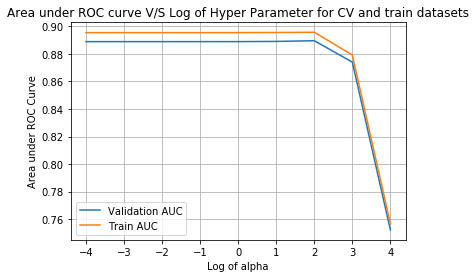

ROC AUC for test data 0.8902978874234593


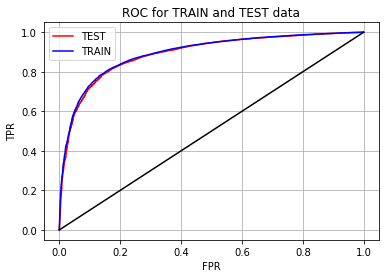

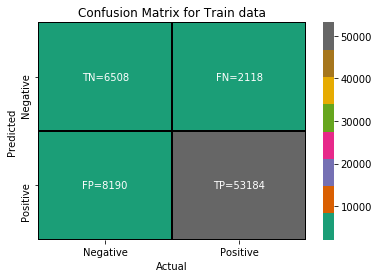

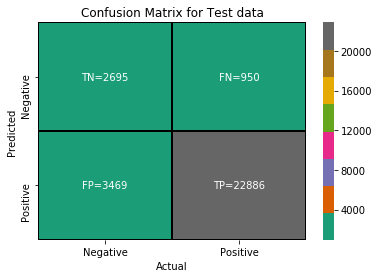

set1_optimal_alpha: 100 set1_best_auc: 0.8902978874234593


In [106]:
# Please write all the code with proper documentation

#######
# BOW #
#######

print('---------------------- BOW--------------------------')

# train the grid and find optimal number of neighbors
grid.fit(set1_x,train_y)    
set1_optimal_alpha=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set1_clf=MultinomialNB(fit_prior=True,alpha=set1_optimal_alpha)

# find the test dataset roc auc and predicted class labels
set1_auc_and_Ypred=plot_roc_curve(set1_x,train_y,set1_x_test,test_y,set1_clf)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set1_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set1_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# Store the set1 results
print('set1_optimal_alpha:',set1_optimal_alpha,'set1_best_auc:',set1_auc_and_Ypred['best_auc'])
set1_result=['BOW','Naive Bayes:Attempt3',set1_optimal_alpha,set1_auc_and_Ypred['best_auc']]


<b> From Naive Bayes model we will get coef_ and from BOW vectorizer we will get feature names. Using these two we find top 10 positive and negative class important features. </b>

In [107]:
# feature importance of attempt3


set1_feature_importance=pd.DataFrame([set1_count_vect.get_feature_names(),list(set1_clf.feature_log_prob_[1][:500])],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features

,feature,log_probability
175,flavor,-5.35083
348,product,-5.34639
435,taste,-5.2833
310,one,-5.28294
37,best,-5.2119
263,love,-5.19884
250,like,-5.14462
203,good,-4.98375
302,not,-4.89688
206,great,-4.85479


In [109]:
# Please write all the code with proper documentation

set1_feature_importance=pd.DataFrame([set1_count_vect.get_feature_names(),list(set1_clf.feature_log_prob_[0][:500])],index=['feature','log_probability']).T

set1_feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 negative class features

,feature,log_probability
299,no,-5.16035
310,one,-5.14881
285,money,-5.10225
28,bad,-5.08379
127,disappointed,-5.0333
348,product,-4.94189
435,taste,-4.93261
250,like,-4.90393
492,would,-4.86083
302,not,-4.25965


<b> Plot Area under ROC curve V/S Alpha for train and cross validation data, ROC curve for train and test data, confusion matrix for set2(TFIDF) data.</b>

--------------- TFIDF-------------------


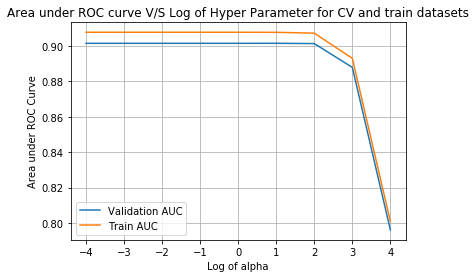

ROC AUC for test data 0.904516729606494


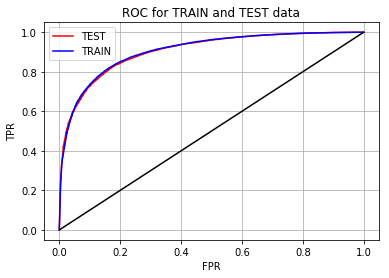

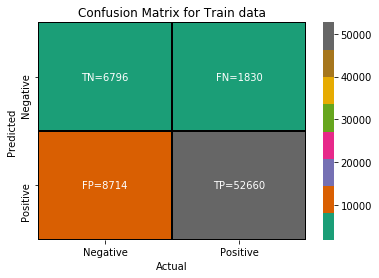

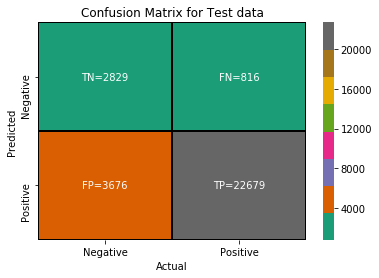

set2_optimal_alpha: 10 set2_best_auc: 0.904516729606494


In [111]:

# Please write all the code with proper documentation

########
# TFIDF#
########

print('--------------- TFIDF-------------------')

# train the grid and find optimal number of neighbors
grid.fit(set2_x,train_y)
set2_optimal_alpha=plot_auc_vs_hyperpameter(param_grid,grid)

# train knn with optimal number of neighbors
set2_clf=MultinomialNB(fit_prior=True,alpha=set2_optimal_alpha)

# find the test dataset roc auc and predicted class labels
set2_auc_and_Ypred=plot_roc_curve(set2_x,train_y,set2_x_test,test_y,set2_clf)

# plot confusion matrix for train data
plot_confusion_matrix(train_y,set2_auc_and_Ypred['y_pred_train'],dataset_type='Train')


# plot confusion matrix for test data
plot_confusion_matrix(test_y,set2_auc_and_Ypred['y_pred_test'],dataset_type='Test')

# store the set2 results
print('set2_optimal_alpha:',set2_optimal_alpha,'set2_best_auc:',set2_auc_and_Ypred['best_auc'])
set2_result=['TFIDF','Naive Bayes:Attempt3',set2_optimal_alpha,set2_auc_and_Ypred['best_auc']]




<b> From Naive Bayes model we will get coef_ and from TFIDF vectorizer we will get feature names. Using these two we find top 10 positive and negative class important features. </b> 

In [112]:
# Please write all the code with proper documentation

feature_importance=pd.DataFrame([set2_tfidf_vect.get_feature_names(),list(set2_clf.feature_log_prob_[1][:500])],index=['feature','log_probability']).T

feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 postive class features


,feature,log_probability
165,flavor,-5.33698
347,product,-5.31792
431,taste,-5.27067
309,one,-5.26072
37,best,-5.25228
255,love,-5.2217
242,like,-5.11108
193,good,-5.01072
196,great,-4.89265
294,not,-4.77272


In [114]:
# Please write all the code with proper documentation

feature_importance=pd.DataFrame([set2_tfidf_vect.get_feature_names(),list(set2_clf.feature_log_prob_[0][:500])],index=['feature','log_probability']).T

feature_importance.sort_values(by='log_probability')[-10:]  # Top 10 Negative class features


,feature,log_probability
493,would not,-5.09793
309,one,-5.06947
276,money,-5.06611
28,bad,-5.01514
118,disappointed,-5.00472
347,product,-4.98754
431,taste,-4.8653
242,like,-4.79902
492,would,-4.76837
294,not,-3.99305


# [6] Conclusions

<b>Tabulate the results and print the table. Below table contains the results from BOW and TFIDF for Attempt1, Attempt2 and Attempt3</b>

In [116]:
# Please compare all your models using Prettytable library

# Pretty table append the results.
# We will use set1 and set2 for Naive Bayes implementations for BOW and TFIDF respectively.

table.add_row(set1_result)
table.add_row(set2_result)

# print the table
print(table)

+------------+----------------------+----------------+--------------------+
| Vectorizer |        Model         | HyperParameter |        AUC         |
+------------+----------------------+----------------+--------------------+
|    BOW     | Naive Bayes:Attempt1 |      100       | 0.865500230445388  |
|   TFIDF    | Naive Bayes:Attempt1 |      100       | 0.8787793707266434 |
|    BOW     | Naive Bayes:Attempt2 |      100       | 0.8653955241806306 |
|   TFIDF    | Naive Bayes:Attempt2 |       10       |  0.87856180217402  |
|    BOW     | Naive Bayes:Attempt3 |      100       | 0.8902978874234593 |
|   TFIDF    | Naive Bayes:Attempt3 |       10       | 0.904516729606494  |
+------------+----------------------+----------------+--------------------+


<b>

<ol type="1">
    
<li> Comparing above cases, we find that TFIDF or BOW  give more or less similar feature importance e.g. features like "disappointed" have been classifed as negative and features like "great","love" are classified as positive.  </li>
<li> TFIDF performs better than BOW due to higher test AUC as shown above . </li>
<li> We used a feature engineering wherein we added length of review texts and length of summaries as two extra columns but performance of the model has not improved.</li>
<li> We used another feature engineering wherein we combined the review text and review summary. This way we could improve the model performance.(AUC=0.9 for alpha=10) </li>

<li> I have attached an excel containing the confusion matrix for train and test datasets for BOW and TFIDF datasets for Attempt1,Attempt2 and Attempt3. Certainly TFIDF model for Attempt3 has better prediction for true negative and true positives. Also the False positives and False negatives are reduced by adopting this method. This means that model is predicting test dataset more correctly now </li>

</ol>

</b>